In [20]:
d = trainSet[0]

In [ ]:
d.query()

In [1]:
from Reader import Reader
import copy
import json
import sys
import os
import time
from glob import glob
import argparse
import _pickle as cPickle
import subprocess as sp
import multiprocessing as mp
from collections import deque

import numpy as np
import pandas as pd
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model as lm
import seaborn as sns
from matplotlib import pyplot as plt

from run_model import *
import root_pandas as rp
import uproot

%matplotlib inline

Welcome to JupyROOT 6.18/04


Using TensorFlow backend.
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/afs/desy.de/user

### Parameters definition

In [2]:
channel = 'mt'
era = '2018'
samples = f'conf/global_config_{channel}_{era}.json'
use = 'keras'

# train = False
# short = True
# datacard = False
# add_nominal = False

In [3]:
read = Reader(channel = channel, config_file = samples, folds=2, era = era)

In [4]:
target_names = read.config["target_names"]
variables = read.config["variables"]

models_folder = era + "/models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

modelname = f'{models_folder}/{channel}.{use}'
scaler = None

### Tests for Reader()

In [5]:
read.config['samples']['qqH125']

{'target': 0,
 'select': 'os > 0.5 & byMediumDeepTau2017v2p1VSjet_2 > 0.5 & iso_1 < 0.15',
 'name': '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018/mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root',
 'event_weight': '( gen_sm_htt125 *  weight * ( 0.95+0.02*( (jpt_1>0 & jpt_1<200) & (njets<2 | ( (jdeta<2.8 | mjj<400 ) & (mjj<60 | mjj>=120 ) ) ) ) - 0.1*(jpt_1>=200) ) * ( 0.8*(gen_match_2 == 5) + 1.*(gen_match_2 !=5) ) )',
 'target_name': 'higgs'}

In [6]:
read.config['target_names']

{0: 'higgs', 1: 'taus', 2: 'fakes', -1: 'none'}

In [7]:
read.config['samples']['W']['target']

2

In [8]:
read.config['samples']['W']['target_name']

'fakes'

### Tests for uproot 

In [15]:
p = '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/In_Tuples_2018'
f = uproot.open(f'{p}/mt-NOMINAL_ntuple_Diboson_2018.root')
t = f['TauCheck']

In [23]:
df = t.pandas.df()

In [32]:
df.columns

Index(['run', 'pt_1', 'eta_1', 'phi_1', 'gen_match_1', 'iso_1', 'puppimt_1',
       'ipx_1', 'ipy_1', 'ipz_1', 'IP_signif_PV_with_BS_1', 'pt_2', 'eta_2',
       'phi_2', 'gen_match_2', 'puppimt_2', 'tau_decay_mode_2', 'dmMVA_2',
       'ipx_2', 'ipy_2', 'ipz_2', 'IP_signif_PV_with_BS_2', 'weight', 'njets',
       'mjj', 'jdeta', 'dijetpt', 'jpt_1', 'jpt_2', 'jeta_1', 'jeta_2',
       'm_vis', 'pt_tt', 'mt_tot', 'm_sv', 'pt_sv', 'puppimet', 'os', 'nbtag',
       'byVVVLooseDeepTau2017v2p1VSjet_2', 'byMediumDeepTau2017v2p1VSjet_2',
       'acotautau_refitbs_00', 'acotautau_refitbs_01', 'acotautau_helix_00',
       'acotautau_helix_01', 'xsec_lumi_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys',
       'gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125', 'gen_minusmm_htt125',
       'gen_mix0p375_htt125'],
      dtype='object')

In [20]:
# test_filename = 'mt-NOMINAL_ntuple_Diboson_2018.root'
# test_treename = 'TauCheck_CMS_scale_j_BBEC113TeVDown'
test_filename = 'mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root'
test_treename = 'TauCheck'

# mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
# mydf = mytree.pandas.df()

#### all branches

In [21]:
%%timeit
df_up = rp.read_root(f"{read.config['path']}/{test_filename}", key=test_treename)

56 s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
mydf = mytree.pandas.df()

14.5 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### several branches

In [9]:
test_filename = 'mt-NOMINAL_ntuple_EmbeddedMuTau_2018.root'
test_treename = 'TauCheck'

In [10]:
test_branches = ['run', 'pt_1', 'eta_1', 'phi_1', 'gen_match_1', 'iso_1', 'puppimt_1',
       'ipx_1', 'ipy_1', 'ipz_1', 'IP_signif_PV_with_BS_1', 'pt_2', 'eta_2',
       'phi_2', 'gen_match_2', 'puppimt_2', 'tau_decay_mode_2', 'dmMVA_2',
       'ipx_2', 'ipy_2', 'ipz_2', 'IP_signif_PV_with_BS_2', 'weight', 'njets',
       'mjj', 'jdeta', 'dijetpt', 'jpt_1', 'jpt_2', 'jeta_1', 'jeta_2',
       'm_vis', 'pt_tt', 'mt_tot', 'm_sv', 'pt_sv', 'puppimet', 'os', 'nbtag',
       'byVVVLooseDeepTau2017v2p1VSjet_2', 'byMediumDeepTau2017v2p1VSjet_2',
       'acotautau_refitbs_00', 'acotautau_refitbs_01', 'acotautau_helix_00',
       'acotautau_helix_01', 'xsec_lumi_weight', 'prefiring_weight',
       'htxs_reco_flag_ggh', 'htxs_reco_flag_qqh', 'ff_nom', 'ff_sys',
       'gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125', 'gen_minusmm_htt125',
       'gen_mix0p375_htt125']

In [ ]:
%%time
df_rp = rp.read_root(f"{read.config['path']}/{test_filename}", key=test_treename, columns=test_branches[:20])

In [46]:
%%time
mytree_uproot = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
df_uproot = mytree_uproot.pandas.df(test_branches[:20])

CPU times: user 4.94 s, sys: 1.19 s, total: 6.13 s
Wall time: 6.03 s


#### one branch

In [24]:
%%timeit
df_up = rp.read_root(f"{read.config['path']}/{test_filename}", columns = 'pt_2', key=test_treename)

1.2 s ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
mydf = mytree.pandas.df(branches='pt_2')

356 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### **Training data + scaling**

In [9]:
%%time
trainSet = read.getSamplesForTraining()

Loading: TJ from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck
size of TJ is 6454
Loading: TL from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck
size of TL is 3491
Loading: TT from mt-NOMINAL_ntuple_SingleTop_2018.root, tree = TauCheck
size of TT is 441
Loading: TTJ from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck
size of TTJ is 10418
Loading: TTL from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck
size of TTL is 52280
Loading: TTT from mt-NOMINAL_ntuple_TTbar_2018.root, tree = TauCheck
size of TTT is 6609
Loading: VVJ from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck
size of VVJ is 1496
Loading: VVL from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck
size of VVL is 3680
Loading: VVT from mt-NOMINAL_ntuple_Diboson_2018.root, tree = TauCheck
size of VVT is 1747
Loading: W from mt-NOMINAL_ntuple_WJets_2018.root, tree = TauCheck
size of W is 17842
Loading: ZJ from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck
size of ZJ is 9118
Loading: ZL 

In [10]:
scaler = trainScaler(trainSet, variables )
with open("{0}/StandardScaler.{1}.pkl".format(models_folder,channel), 'wb') as FSO:
    pickle.dump(scaler, FSO , 2)
scaler = [scaler, scaler] # Hotfix since KIT uses 2 scalers
trainSet = applyScaler(scaler, trainSet, variables)

### **Looking into trainSet data**

In [11]:
data = trainSet[1]

In [12]:
data.head()

,pt_2,jpt_1,jpt_2,njets,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
0,-0.264138,0.279096,0.986585,0.753062,-0.063955,1.405820,0.101988,1.657341,1.589535,0.686236,0,1.531491,54096030,0.007345
1,-0.855204,-0.389077,-0.674310,-0.174887,-0.522814,1.367238,-0.883310,-0.485763,-0.764818,-0.609965,0,6.949815,47005890,0.033332
2,-0.652252,0.111550,1.005085,0.753062,-0.574093,-1.329406,-0.196257,1.547662,1.596267,0.262730,0,2.299709,13380000,0.011030
3,0.692803,1.338945,0.828438,0.753062,0.213427,-1.338299,1.477282,4.528494,1.762198,1.749751,0,1.026919,84822422,0.004925
4,-0.765442,-0.948818,-0.674310,-1.102836,-0.743353,0.462752,-0.715056,-0.485763,-0.764818,-0.609965,1,276.624783,212580338,184.416522


In [13]:
data.columns

Index(['pt_2', 'jpt_1', 'jpt_2', 'njets', 'm_sv', 'puppimt_1', 'pt_tt', 'mjj',
       'jdeta', 'dijetpt', 'target', 'train_weight', 'evt', 'event_weight'],
      dtype='object')

In [14]:
np.unique(data.target)

array([0, 1, 2])

### **NaNs**

In [15]:
nan_args = np.argwhere(data.train_weight.isna())
print(f'got {nan_args.shape[0]} NaNs here')

got 2 NaNs here


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [16]:
data.iloc[nan_args[0]]

,pt_2,jpt_1,jpt_2,njets,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
410315,-0.048573,0.816373,-0.67431,-0.174887,-0.23011,1.96085,1.37565,-0.485763,-0.764818,-0.609965,0,NaN,60372980,NaN


In [17]:
data.iloc[nan_args[1]]

,pt_2,jpt_1,jpt_2,njets,m_sv,puppimt_1,pt_tt,mjj,jdeta,dijetpt,target,train_weight,evt,event_weight
949281,0.16709,1.430804,0.835269,1.681011,0.159958,0.69868,2.555698,-0.316061,0.770004,1.998089,0,NaN,11831576,NaN


In [34]:
data.columns[(np.sum(data.isna())) != 0].values

array(['train_weight', 'event_weight'], dtype=object)

In [30]:
np.sum(data.isna()).sum()

4

In [149]:
test_filename = 'mt-NOMINAL_ntuple_VBFHToUncorrTauTau_2018.root'
test_treename = 'TauCheck'

In [150]:
mytree = uproot.open(f"{read.config['path']}/{test_filename}")[test_treename]
df = mytree.pandas.df(['gen_sm_htt125', 'evt'])

In [152]:
df[df.isna().values]

,gen_sm_htt125,evt
entry,,
92476,NaN,11831576
1763135,NaN,60372980


In [142]:
11831576 in df.evt.values

True

In [12]:
trainSet[0].dropna(inplace=True)
trainSet[1].dropna(inplace=True)

### **Defining model and training**

In [11]:
if use == 'keras':
    from KerasModel import KerasObject as modelObject
    parameters = "conf/parameters_keras.json"
if use == 'xgb':
    from XGBModel import XGBObject as modelObject
    parameters = "conf/parameters_xgb.json"

In [30]:
model = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )


In [31]:
model.params

{'name': 'smhtt_dropout_tanh',
 'batch_size': 10000,
 'epochs': 3,
 'early_stopping': 50}

In [32]:
model.variables

['pt_2',
 'jpt_1',
 'jpt_2',
 'njets',
 'm_sv',
 'puppimt_1',
 'pt_tt',
 'mjj',
 'jdeta',
 'dijetpt']

In [33]:
model.train( trainSet )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_7 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_8 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 603       
__________

In [34]:
model.models

In [35]:
modelname

'2018/models/mt.keras'

In [36]:
model.__dict__

{'variables': ['pt_2',
  'jpt_1',
  'jpt_2',
  'njets',
  'm_sv',
  'puppimt_1',
  'pt_tt',
  'mjj',
  'jdeta',
  'dijetpt'],
 'models': [<keras.models.Sequential at 0x2b6af193ce48>,
 'params': {'name': 'smhtt_dropout_tanh',
  'batch_size': 10000,
  'epochs': 3,
  'early_stopping': 50},
 'target_names': {0: 'higgs', 1: 'taus', 2: 'fakes', -1: 'none'}}

In [37]:
# Save models
model.models[0].save(modelname + "_v0_3epochs.fold0")
model.models[1].save(modelname + "_v0_3epochs.fold1")

### Load model

In [12]:
model_loaded = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )

In [13]:
model_loaded.models = []
model_loaded.models.append( lm(modelname + "_v0_30epochs.fold0") )
model_loaded.models.append( lm(modelname + "_v0_30epochs.fold1") )


2020-02-04 23:24:46.717786: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [14]:
model_loaded.__dict__

{'variables': ['pt_2',
  'jpt_1',
  'jpt_2',
  'njets',
  'm_sv',
  'puppimt_1',
  'pt_tt',
  'mjj',
  'jdeta',
  'dijetpt'],
 'models': [<keras.models.Sequential at 0x2b9005e44748>,
 'params': {'name': 'smhtt_dropout_tanh',
  'batch_size': 10000,
  'epochs': 3,
  'early_stopping': 50},
 'target_names': {0: 'higgs', 1: 'taus', 2: 'fakes', -1: 'none'}}

### Prediction

In [15]:
from run_model import sandbox

In [16]:
outpath = read.config["outpath"] + "/predictions_" + era
if not os.path.exists(outpath):
    os.mkdir(outpath)    
predictions = {}

In [17]:
# Deleting root files in outpath
files = glob(outpath + '/*.root')
for f in files:
    os.remove(f)

In [19]:
%%time
for sample, sampleConfig in read.get(what = "full", add_jec = True, for_prediction = True):
    if "data" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables, "NOMINAL_ntuple_SingleMuon_2018", outpath, sampleConfig, read.modifyDF)
    elif "full" in sampleConfig["histname"]:
        sandbox(channel, model_loaded, scaler, sample, variables,  "NOMINAL_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )
    else:
        splName = sampleConfig["histname"].split("_")
        sandbox(channel, model_loaded, scaler, sample, variables,  "_".join(splName[1:])+"_ntuple_" + sampleConfig["histname"].split("_")[0], outpath, sampleConfig, read.modifyDF )

Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong_13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_1prong1pi0_13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_shape_t_3prong_13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_FlavorQCD13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_RelativeBal13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_HF13TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_BBEC113TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_EC213TeVUp
Loading: DY_full from mt-NOMINAL_ntuple_DYJets_2018.root, tree = TauCheck_CMS_scale_j_Absolute13TeVUp
Loading: DY_full 

### Tests with NN predictions

In [45]:
DY_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_HF13TeVUp')
DY_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck_CMS_scale_j_HF13TeVDown')
DY_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_DY.root', key='TauCheck')

In [16]:
ggH_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_HF13TeVUp')
ggH_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck_CMS_scale_j_HF13TeVDown')
ggH_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ggH125.root', key='TauCheck')

In [46]:
sns.distplot(DY_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(DY_predict_down.predicted_prob, label='Down', hist=False)
sns.distplot(DY_predict_center.predicted_prob, label='Center', hist=False)
plt.legend()
plt.title('DY')

Text(0.5, 1, 'DY')

Text(0.5, 1.0, 'ggH')

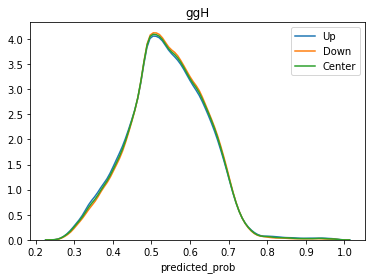

In [18]:
sns.distplot(ggH_predict_up.predicted_prob, label='Up', hist=False)
sns.distplot(ggH_predict_down.predicted_prob, label = 'Down', hist=False)
sns.distplot(ggH_predict_center.predicted_prob, label = 'Center', hist=False)
plt.legend()
plt.title('ggH')